## Disaster or Not Tweet Analysis Using LSTM With PyTorch

References:  
nbshare.io/notebooks  
Tweet Sentiment Analysis Using LSTM With PyTorch  
  
datacamp.com/tutorial  
NLP with PyTorch: A Comprehensive Guide by Moez Ali  

### Imports and Data Loading

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/soonglee/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
batch_size = 50
batch_size_train = 50
max_len = 28

In [4]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

### Import the preprocessed data

In [5]:
df_word_list = pd.read_csv('tweets_5000/vocab/word_list.csv')

In [6]:
word_list = df_word_list.iloc[:,0].to_list()

In [7]:
vocab_count = Counter(word_list)

In [8]:
vocab = sorted(vocab_count,key=vocab_count.get,reverse=True)[:5000]

In [9]:
count_words = sorted(vocab_count.values(), reverse=True)
len(count_words)

12495

In [10]:
# words with more than one occurrence
words_more_than_1 = list(filter(lambda x: x > 1, count_words))
len(words_more_than_1)

5469

In [11]:
words_less_than_50 = list(filter(lambda x: x < 50, count_words))

In [12]:
vocab_all = sorted(vocab_count,key=vocab_count.get,reverse=True)

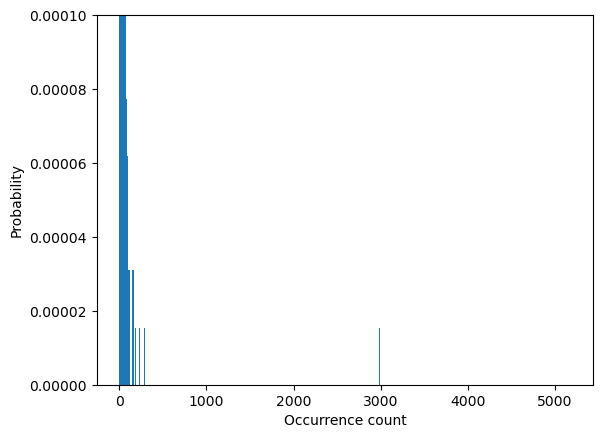

In [13]:
x = np.arange(1, len(vocab_all)+1)
plt.hist(count_words, density=True, bins=1000)  # density=False would make counts
plt.ylim(0, 0.0001)
#plt.xlim(0, 10)
plt.ylabel('Probability')
plt.xlabel('Occurrence count');

In [14]:
np.arange(1, len(vocab_all)+1)

array([    1,     2,     3, ..., 12493, 12494, 12495])

In [15]:
vocab_dict = {w:i+1 for i,w in enumerate(vocab)}

In [16]:
# Read the tokenized data (csv files) saved from data preprocessing step (vocabulary of 5000)

In [17]:
df_x_train_padded = pd.read_csv('tweets_5000/train/x_train_padded.csv')
df_x_valid_padded = pd.read_csv('tweets_5000/valid/x_valid_padded.csv')
df_X_test = pd.read_csv('tweets_5000/test/X_test.csv')
df_y_test = pd.read_csv('tweets_5000/test/y_test.csv')
df_y_train = pd.read_csv('tweets_5000/train/y_train.csv')
df_y_valid = pd.read_csv('tweets_5000/valid/y_valid.csv')

In [18]:
df_x_train_padded.head(3)

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,442,1053,461,511,559,35,1054,442,1,2,...,0,0,0,0,0,0,0,0,0,0
1,18,560,1,793,18,1803,561,1242,627,512,...,0,0,0,0,0,0,0,0,0,0
2,118,1,1243,1,53,1806,2649,118,30,513,...,0,0,0,0,0,0,0,0,0,0


In [19]:
# convert dataframe  to numpy array
x_train_padded = df_x_train_padded.to_numpy()
x_valid_padded = df_x_valid_padded.to_numpy()
X_test = df_X_test.to_numpy().squeeze()
y_test = df_y_test.to_numpy().squeeze()
y_train = df_y_train.to_numpy().squeeze()
y_valid = df_y_valid.to_numpy().squeeze()

### Create final dataset for training

In [20]:
x_train_padded = np.array(x_train_padded)
x_valid_padded = np.array(x_valid_padded)

In [21]:
len(x_train_padded)

5210

In [22]:
len(x_valid_padded)

1737

In [23]:
# Create tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_padded), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(x_valid_padded), torch.from_numpy(y_valid))

In [24]:
# Set up dataloader with shuffle on
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
valid_dataloader = DataLoader(valid_data, batch_size=batch_size, shuffle=True, drop_last=True)

In [25]:
# Display tweet and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([50, 28])
Labels batch shape: torch.Size([50])


In [26]:
tweet_0 = train_features[0].squeeze()
label_0 = train_labels[0]
print(f"Tweet: {tweet_0}\nLabel: {label_0}")

Tweet: tensor([ 174,  743,    1,   10,  174, 4921, 2443, 4922,    1,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0])
Label: 0


### Prediction

In [27]:
class TweetLSTM(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim, dropout) :
        super().__init__()

        # The embedding layer takes the vocab size and the embeddings size as input
        # The embeddings size is up to you to decide, but common sizes are between 50 and 100.
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # The LSTM layer takes in the the embedding size and the hidden vector size.
        # The hidden dimension is up to you to decide, but common values are 32, 64, 128
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)

        # We use dropout before the final layer to improve with regularization
        self.dropout = nn.Dropout(dropout)

        # The fully-connected layer takes in the hidden dim of the LSTM and
        #  outputs a 2x1 vector of the class scores.
        self.fc = nn.Linear(hidden_dim, 2)

    def forward(self, x, hidden):
        """
        The forward method takes in the input and the previous hidden state 
        """

        # The input is transformed to embeddings by passing it to the embedding layer
        embs = self.embedding(x)

        # The embedded inputs are fed to the LSTM alongside the previous hidden state
        out, hidden = self.lstm(embs, hidden)

        # Dropout is applied to the output and fed to the FC layer
        out = self.dropout(out)
        out = self.fc(out)

        # We extract the scores for the final hidden state since it is the one that matters.
        out = out[:, -1]
        return out, hidden
    
    def init_hidden(self, batch_size):
        return (torch.zeros(1, batch_size, 32), torch.zeros(1, batch_size, 32))

In [28]:
# vocabulary size = maximum integer index + 1
vocab_size = len(vocab) + 1

In [29]:
model = TweetLSTM(vocab_size, 64, 32, 0.2)
model = model.to(device)

In [30]:
lr = 3e-4
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

In [31]:
epochs = 50
losses = []
for e in range(epochs):

    h0, c0 =  model.init_hidden(batch_size_train)

    h0 = h0.to(device)
    c0 = c0.to(device)

    for batch_idx, batch in enumerate(train_dataloader):

        input = batch[0].to(device)
        target = batch[1].to(device)

        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
            out, hidden = model(input, (h0, c0))
            loss = criterion(out, target)
            loss.backward()
            optimizer.step()
    losses.append(loss.item())

Text(0.5, 0, 'Epoch')

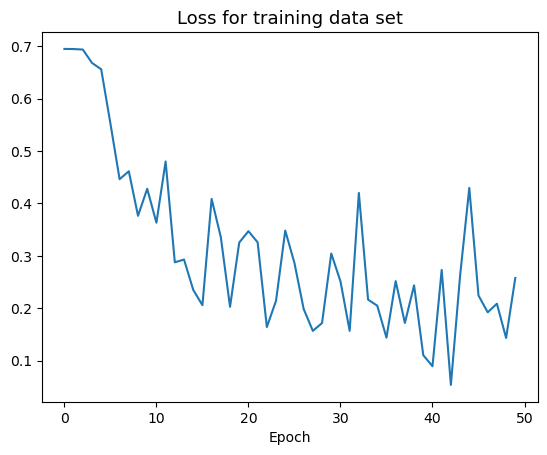

In [32]:
# This plot is just to see if the modeling is working (sanity check)
plt.plot(losses)
plt.title("Loss for training data set", fontsize=13)
plt.xlabel('Epoch')

In [33]:
# function to predict accuracy. pred will have 0 or 1, where 0 is non-disaster.
def acc(out,label):
    _, pred = torch.max(out, 1)
    return torch.sum(pred == label)

In [34]:
model = TweetLSTM(vocab_size, 64, 32, 0.2)
model = model.to(device)

In [35]:
lr = 3e-4
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

In [36]:
clip = 5
epochs = 50
valid_loss_min = np.inf
# train for some number of epochs
epoch_tr_loss, epoch_vl_loss = [],[]
epoch_tr_acc, epoch_vl_acc = [],[]

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    # initialize hidden state
    h = model.init_hidden(batch_size)
    for inputs, labels in train_dataloader:
       
        inputs, labels = inputs.to(device), labels.to(device)  
        # Get a new copy of initialized h, leaving the original h unchanged.
        h = tuple([x.data for x in h])
       
        model.zero_grad()
        output, h = model(inputs, h)
        # calculate the loss and perform backpropagation
        loss = criterion(output, labels)
        loss.backward()
        train_losses.append(loss.item())
        # calculating accuracy
        accuracy = acc(output,labels)
        train_acc += accuracy
        # clip helps prevent the exploding gradient problem in LSTM.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

    # Evaluate the model with x_valid data set
    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_dataloader:
            val_h = tuple([each.data for each in val_h])
            inputs, labels = inputs.to(device), labels.to(device)
            output, val_h = model(inputs, val_h)
            val_loss = criterion(output, labels)
            val_losses.append(val_loss.item())           
            accuracy = acc(output,labels)
            val_acc += accuracy
           
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_dataloader.dataset)
    epoch_val_acc = val_acc/len(valid_dataloader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}')
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    print(30 * '==')

Epoch 1
train_loss : 0.6934061222351514 val_loss : 0.694890616571202
train_accuracy : 50.94050216674805 val_accuracy : 46.28670120239258
Epoch 2
train_loss : 0.6931422071961256 val_loss : 0.6935228004175074
train_accuracy : 50.19194030761719 val_accuracy : 46.11398696899414
Epoch 3
train_loss : 0.6928741696935433 val_loss : 0.6939357694457559
train_accuracy : 50.63339614868164 val_accuracy : 46.056419372558594
Epoch 4
train_loss : 0.6693283399710288 val_loss : 0.6388373970985413
train_accuracy : 60.97888946533203 val_accuracy : 63.557857513427734
Epoch 5
train_loss : 0.6249065341857764 val_loss : 0.6142552284633412
train_accuracy : 66.62187957763672 val_accuracy : 65.80310821533203
Epoch 6
train_loss : 0.5895780356457601 val_loss : 0.5861039862913244
train_accuracy : 69.30902099609375 val_accuracy : 68.27864074707031
Epoch 7
train_loss : 0.5439218612244496 val_loss : 0.5651027753072626
train_accuracy : 73.85796356201172 val_accuracy : 69.25733947753906
Epoch 8
train_loss : 0.5125040833

### Model evaluation

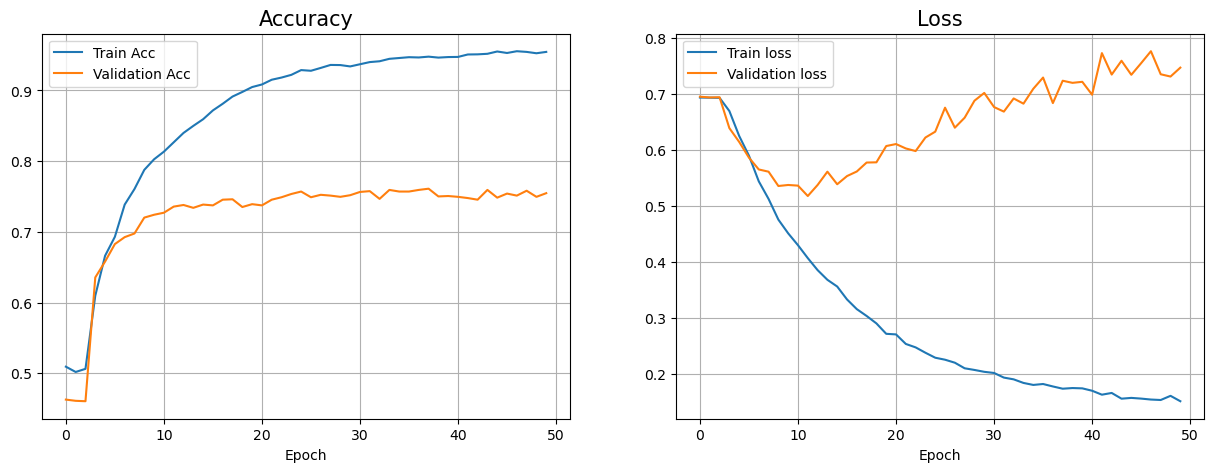

In [37]:
fig = plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy", fontsize=15)
plt.xlabel('Epoch')
plt.legend()
plt.grid()
   
plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss", fontsize=15)
plt.xlabel('Epoch')
plt.legend()
plt.grid()

plt.show()

### Inference / Prediction

For inference, a single tweet will be tested each time.

In [38]:
# Here the argument "tokenized_tweet" is a tokenized tweet without stop words.
def padded_vector(tokenized_tweet, vocab_dict, max_len):
    int_tweet = []
    for word in tokenized_tweet:
        if word in vocab_dict:
            int_tweet.append(vocab_dict[word])  

    padded_vector = int_tweet + [0] * max(0, max_len - len(int_tweet))
    return padded_vector

In [39]:
# Here the argument tweet is the raw text data.
def create_padded_tokens(tweet):
    tweet = re.sub(r'[,!?;-]', '.', tweet) #  Punctuations are replaced by "."
    #tweet_lowered = tweet.lower()
    tokenized_tweet = nltk.word_tokenize(tweet) 
    #  Lower case and drop non-alphabetical tokens
    tokenized_tweet = [ch.lower() for ch in tokenized_tweet if ch.isalpha() or ch == '.']  
    english_stopwords = stopwords.words('english')
    tokens_wo_stopwords = [t for t in tokenized_tweet if t not in english_stopwords]
    tokens_padded = np.array(padded_vector(tokens_wo_stopwords, vocab_dict, max_len))
    tokens_padded = np.expand_dims(tokens_padded, axis=0) # To change 2-d array to 3-d to use in model(inputs, h).

    return tokens_padded

In [40]:
# predict one tweet at a time. (batch_size is set at 1.)
def predict_tweet(tokens_padded):
    pad =  torch.from_numpy(tokens_padded) 
    inputs = pad.to(device)
    # a single tweet will be tested.
    batch_size = 1
    h = model.init_hidden(batch_size)
    h = tuple([each.data for each in h])
    output, h = model(inputs, h)
    out = nn.Sigmoid()(output[0][1])
    return(out.item())   

In [41]:
index = 525
print(X_test[index])
print('='*70)
print(f'Actual target is  : {y_test[index]}')
print('='*70)
tokens_padded = create_padded_tokens(X_test[index])
prob = predict_tweet(tokens_padded)
status = "Disaster" if prob > 0.5 else "Non-disaster"
prob = (1 - prob) if status == "Non-disaster" else prob
print(f'Predicted sentiment is {status} with a probability of {prob}')

seismic NA #Sismo DETECTADO #JapÌ_n [Report 3] 01:02:17 Okinawa Island region M3.8 Depth 10km Maximum seismic intensity 3 JST #??
Actual target is  : 1
Predicted sentiment is Disaster with a probability of 0.9413011074066162


### Test accuracy 

In [42]:
len(X_test)

1737

In [43]:
batch_size_test = 1
all_batches_acc = []
for idx in range(len(X_test)):
    batch_acc = []

    tweet = X_test[idx]
    tokens_padded = create_padded_tokens(tweet)
    prob = torch.tensor(predict_tweet(tokens_padded))
    pred = torch.round(prob)
    target = y_test[idx]
    batch_acc.append(pred == target)
        
    all_batches_acc.extend(batch_acc) 
    
print(sum(all_batches_acc)/len(X_test))   

tensor(0.7611)
